In [11]:
import tensorflow as tf 
from tensorflow.keras.preprocessing import image_dataset_from_directory

import random
import os 

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from helper_plotting import plot_images_from_folder

In [12]:
class CFG:
    train_folder = "./asl_alphabet_train/"
    test_folder = "./asl_alphabet_test/"
    batch_size = 64
    image_size = (64, 64)
    epochs= 25
    seed = 42

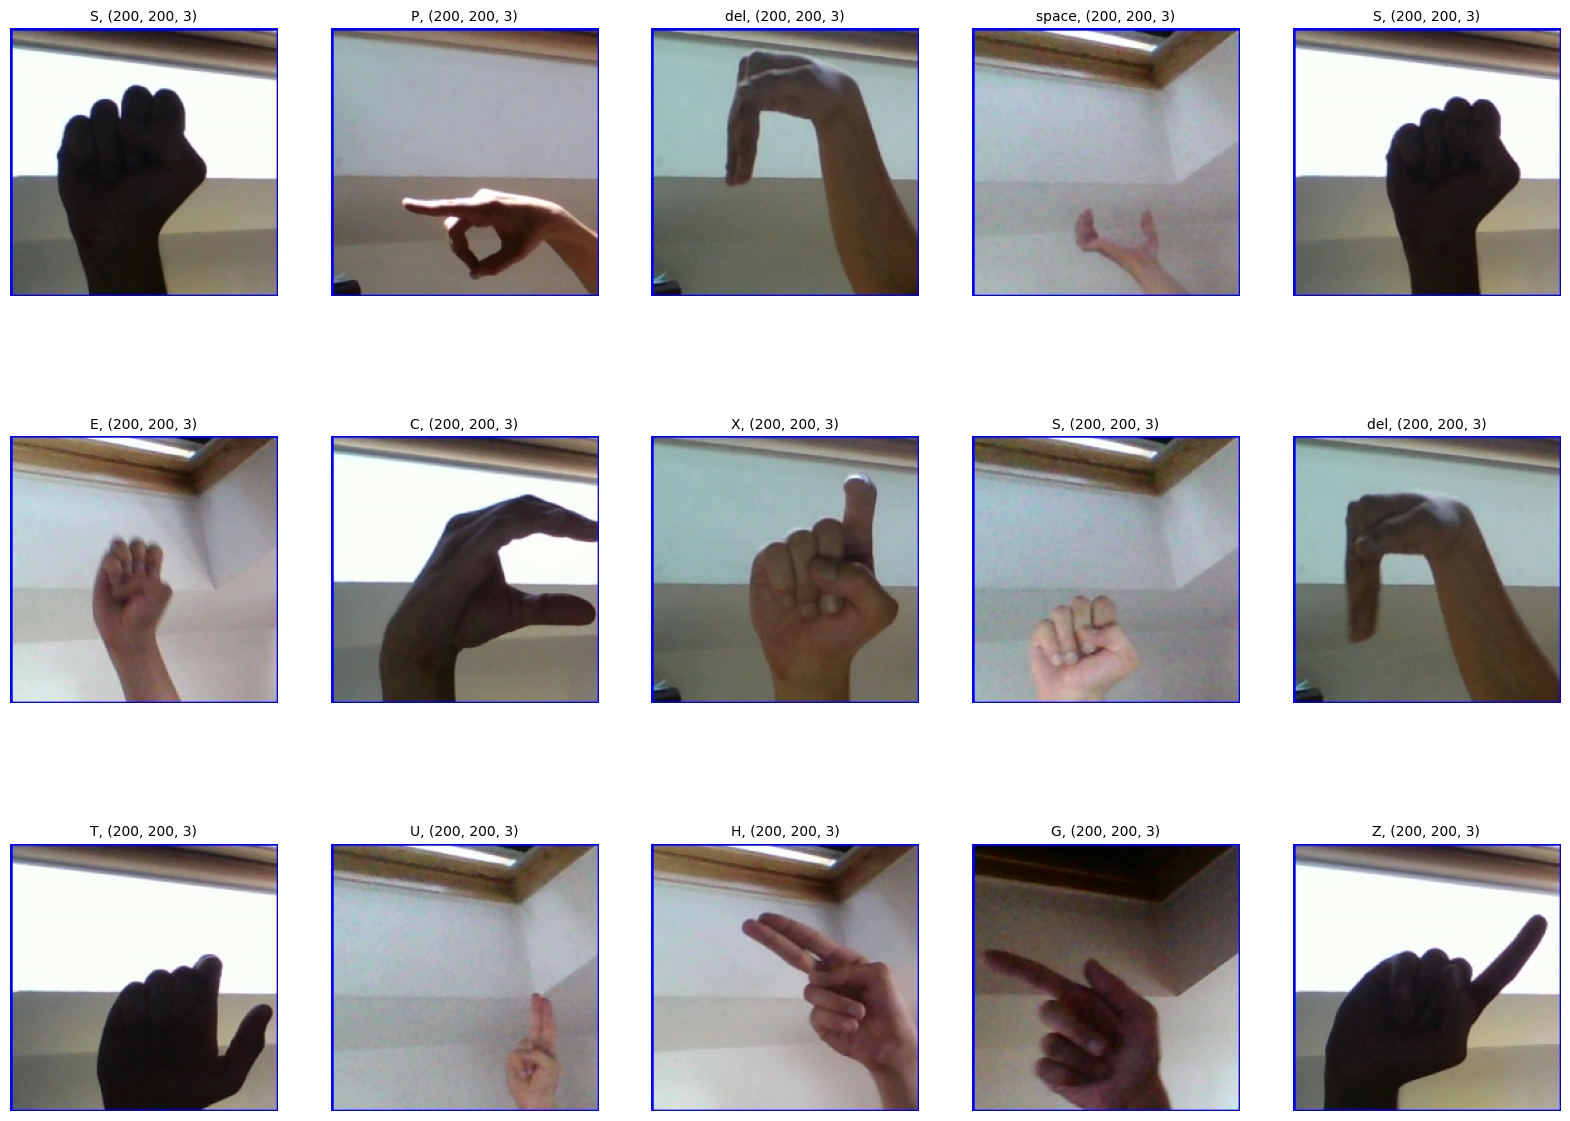

In [13]:
# plot some samples from folder, what about Shape?

plot_images_from_folder(folder=CFG.train_folder, n_images=15, images_per_row=5)

In [14]:
# train dataset with shuffeling, seed for no overlapping
train_dataset = image_dataset_from_directory(CFG.train_folder,
                                             label_mode="categorical",
                                             image_size=CFG.image_size,
                                             shuffle=True,
                                             batch_size=CFG.batch_size,
                                             subset="training",
                                             validation_split=0.2,
                                             seed=CFG.seed)

# valid dataset with shuffeling, seed for no overlapping
valid_dataset = image_dataset_from_directory(CFG.train_folder,
                                             label_mode="categorical",
                                             image_size=CFG.image_size,
                                             shuffle=True,
                                             batch_size=CFG.batch_size,
                                             subset="validation",
                                             validation_split=0.2,
                                             seed=CFG.seed)

# test dataset without shuffeling
test_dataset = image_dataset_from_directory(CFG.test_folder,
                                             label_mode="categorical",
                                             image_size=CFG.image_size,
                                             shuffle=False,
                                             batch_size=CFG.batch_size)

Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
Found 29 files belonging to 29 classes.


In [15]:
# get class names

class_names = train_dataset.class_names 
class_names

['A',
 'B',
 'C',
 'D',
 'E',
 'F',
 'G',
 'H',
 'I',
 'J',
 'K',
 'L',
 'M',
 'N',
 'O',
 'P',
 'Q',
 'R',
 'S',
 'T',
 'U',
 'V',
 'W',
 'X',
 'Y',
 'Z',
 'del',
 'nothing',
 'space']

In [16]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

model = Sequential()

model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(29, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 60, 60, 32)        2432      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 30, 30, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 64)         

In [17]:
from tensorflow.keras import callbacks 

early_stopping = callbacks.EarlyStopping(patience=8, monitor="val_loss", restore_best_weights=True, verbose=0)

reduce_lr_on_plateau = callbacks.ReduceLROnPlateau(patience=4, monitor="val_loss", verbose=1, min_lr=1e-8)

callbacks_list = [early_stopping, reduce_lr_on_plateau]

In [18]:
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import CategoricalCrossentropy 

opt = Adam(learning_rate=1e-4)
loss = CategoricalCrossentropy()

model.compile(optimizer=opt, loss=loss, metrics=["accuracy"])

In [19]:
history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),
    epochs=CFG.epochs,
    validation_data=valid_dataset,
    validation_steps=len(valid_dataset),
    callbacks=callbacks_list
)

Epoch 1/25
1088/1088 [==============================] - 6s 5ms/step - loss: 3.1467 - accuracy: 0.3099 - val_loss: 1.4301 - val_accuracy: 0.5667 - lr: 1.0000e-04
Epoch 2/25
1088/1088 [==============================] - 5s 4ms/step - loss: 0.9189 - accuracy: 0.7177 - val_loss: 0.5799 - val_accuracy: 0.8204 - lr: 1.0000e-04
Epoch 3/25
1088/1088 [==============================] - 5s 4ms/step - loss: 0.3934 - accuracy: 0.8758 - val_loss: 0.2634 - val_accuracy: 0.9177 - lr: 1.0000e-04
Epoch 4/25
1088/1088 [==============================] - 5s 5ms/step - loss: 0.2016 - accuracy: 0.9364 - val_loss: 0.1535 - val_accuracy: 0.9534 - lr: 1.0000e-04
Epoch 5/25
1088/1088 [==============================] - 5s 5ms/step - loss: 0.1161 - accuracy: 0.9640 - val_loss: 0.1075 - val_accuracy: 0.9656 - lr: 1.0000e-04
Epoch 6/25
1088/1088 [==============================] - 5s 5ms/step - loss: 0.0750 - accuracy: 0.9774 - val_loss: 0.0703 - val_accuracy: 0.9778 - lr: 1.0000e-04
Epoch 7/25
1088/1088 [============

In [20]:
# save only weights

model.save("ASL.h5")

In [46]:
# save complete model

model.save("ASL")

INFO:tensorflow:Assets written to: ASL/assets


INFO:tensorflow:Assets written to: ASL/assets


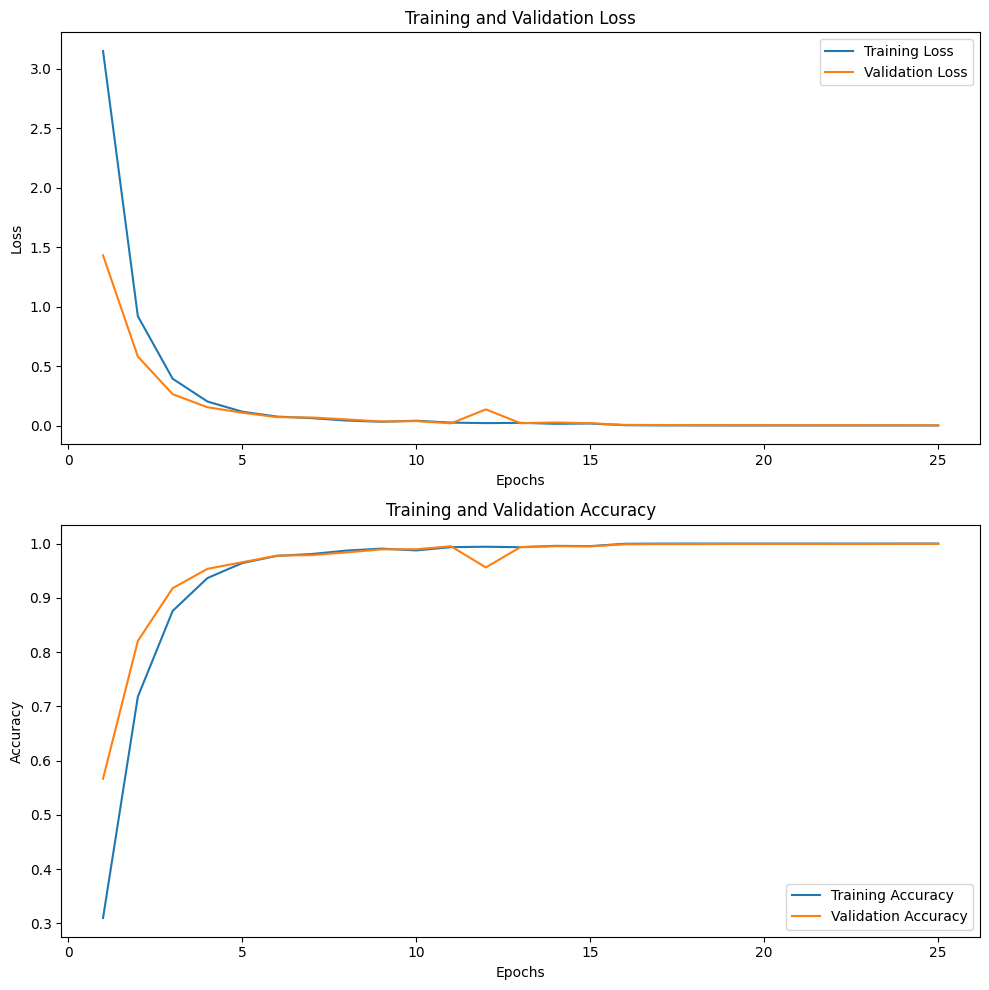

In [23]:
from helper_evaluation import *

# plot accuracy, loss curves
plot_training_history(history=history.history, figsize=(10, 10))

In [30]:
# evaluate the model on test set
loss, accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Accuracy on Test Set: {accuracy * 100}%")

Accuracy on Test Set: 100.0%


In [40]:
# get predictions on test set
y_probs = model.predict(test_dataset, verbose=0)
y_pred = np.argmax(y_probs, axis=1)
y_pred

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28])

In [42]:
y_true = []

# get y_true labels
for images, labels in test_dataset.unbatch():
    labels = np.argmax(labels, axis=-1)
    y_true.append(labels)

print(y_true)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]


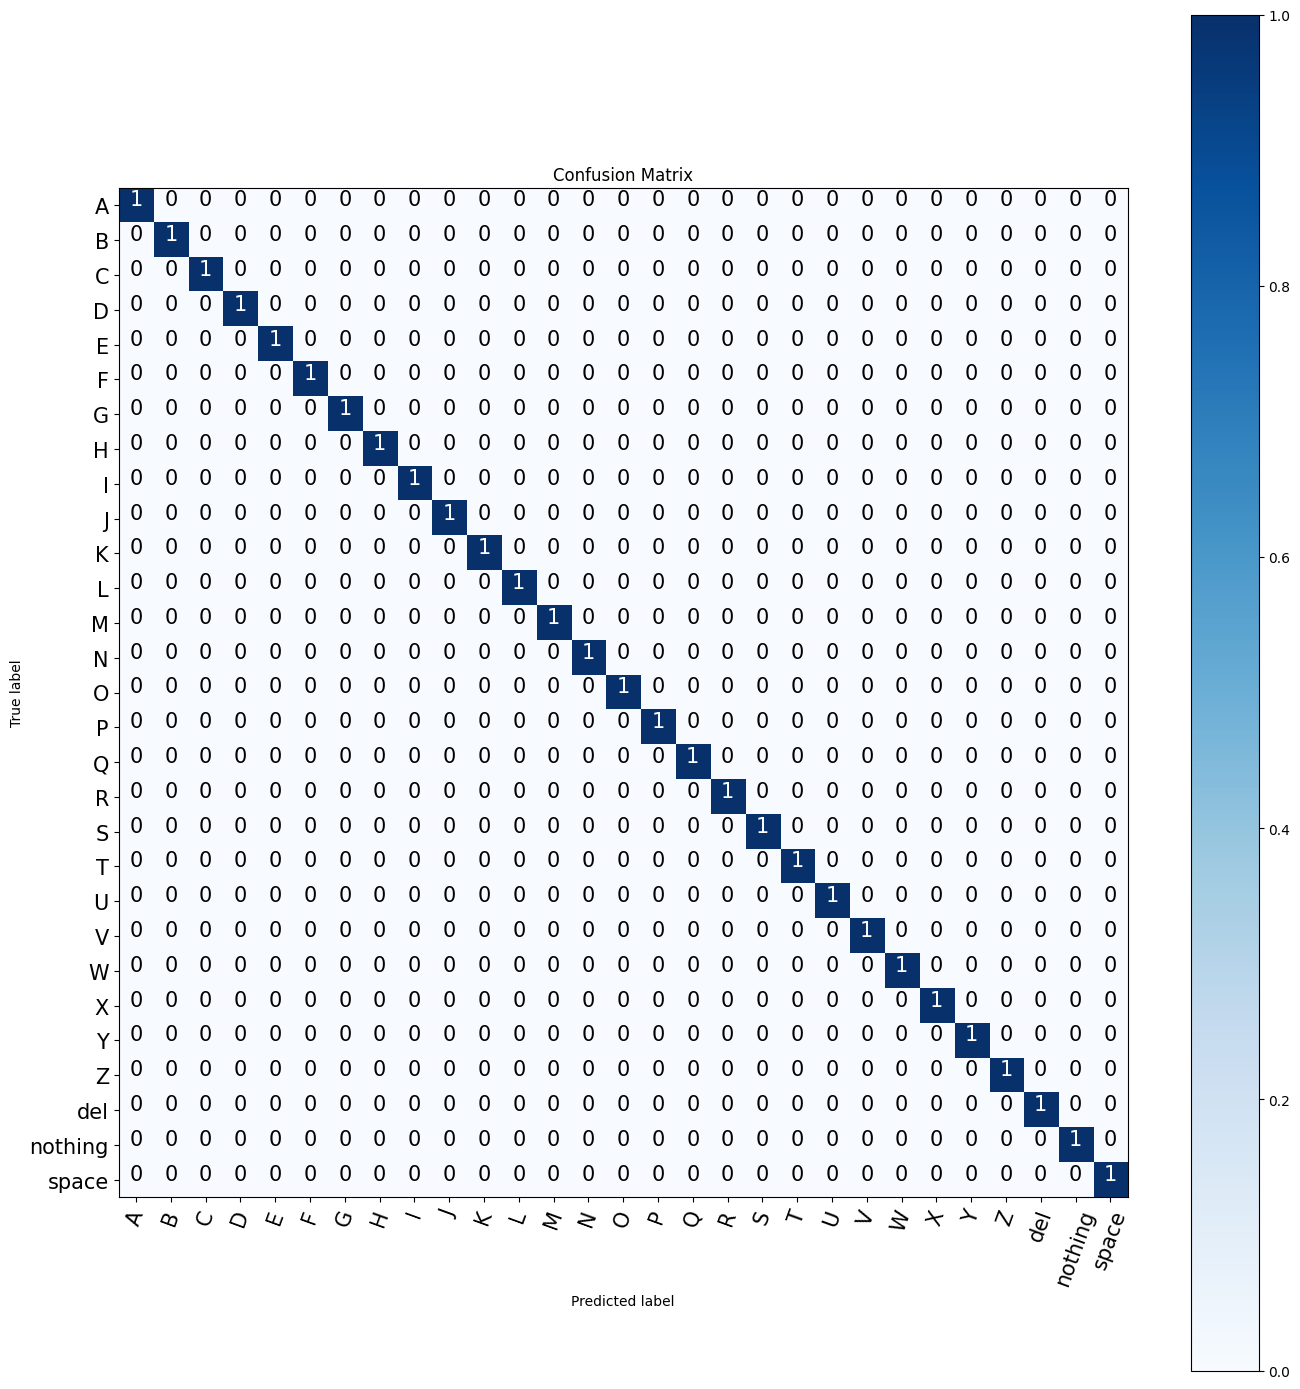

In [45]:
make_confusion_matrix(y_true=y_true, y_pred=y_pred, classes=class_names, figsize=(14, 14))

1/1 [==============================] - 0s 24ms/step


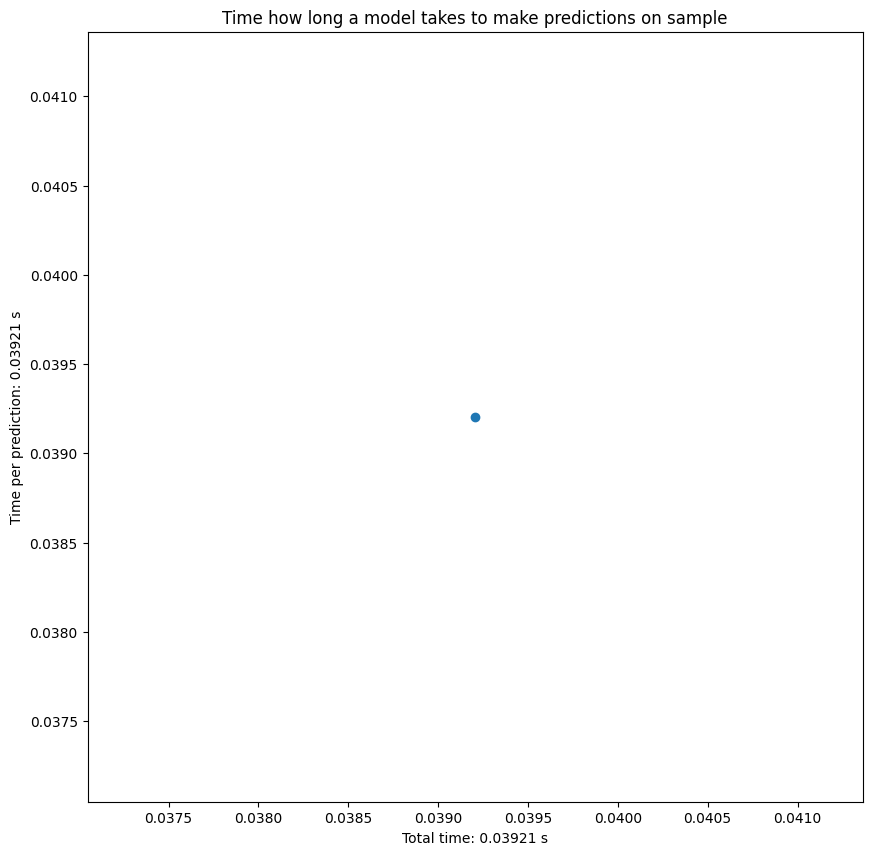

In [48]:
# How fast the Model predicts Samples?

total_time, time_per_pred = show_model_prediction_time(model=model, samples=test_dataset)

In [49]:
from sklearn.metrics import classification_report 

print(classification_report(y_pred=y_pred, y_true=y_true, target_names=class_names))

              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         1
           F       1.00      1.00      1.00         1
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.00         1
           I       1.00      1.00      1.00         1
           J       1.00      1.00      1.00         1
           K       1.00      1.00      1.00         1
           L       1.00      1.00      1.00         1
           M       1.00      1.00      1.00         1
           N       1.00      1.00      1.00         1
           O       1.00      1.00      1.00         1
           P       1.00      1.00      1.00         1
           Q       1.00      1.00      1.00         1
           R       1.00    